# Import Library

In [4]:
import os
import numpy as np
import torch
import pandas as pd
import tensorflow as tf
import torchvision
import seaborn as sns
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from mlxtend.plotting import plot_confusion_matrix
from keras.preprocessing import image
from tensorflow.keras import backend

train_on_gpu = torch.cuda.is_available()

%matplotlib inline

# Generating Dataset from Directory

In [72]:
train_alphabet_dir = 'asl-alphabet/asl_alphabet_train/asl_alphabet_train'
test_alphabet_dir = 'asl-alphabet/asl_alphabet_test/asl_alphabet_test'

In [6]:
train_data = datasets.ImageFolder(train_alphabet_dir)

print('Num training images: ', len(train_data))

Num training images:  87000


## Tranform the Data Into a Dataframe

In [7]:
all_data = []
for folder in os.listdir(train_alphabet_dir):
    
    label_folder = os.path.join(train_alphabet_dir, folder)
    onlyfiles = [{'label':folder,'path':os.path.join(label_folder, f)} for f in os.listdir(label_folder) if os.path.isfile(os.path.join(label_folder, f))]
    #print(onlyfiles)
    all_data += onlyfiles
data = pd.DataFrame(all_data)
data

,label,path
0,A,asl-alphabet/asl_alphabet_train/asl_alphabet_t...
1,A,asl-alphabet/asl_alphabet_train/asl_alphabet_t...
2,A,asl-alphabet/asl_alphabet_train/asl_alphabet_t...
3,A,asl-alphabet/asl_alphabet_train/asl_alphabet_t...
4,A,asl-alphabet/asl_alphabet_train/asl_alphabet_t...
...,...,...
86995,Z,asl-alphabet/asl_alphabet_train/asl_alphabet_t...
86996,Z,asl-alphabet/asl_alphabet_train/asl_alphabet_t...
86997,Z,asl-alphabet/asl_alphabet_train/asl_alphabet_t...
86998,Z,asl-alphabet/asl_alphabet_train/asl_alphabet_t...


# Splitting Data

In [8]:
Xtrain, Xval = train_test_split(data, test_size=0.2, stratify=data[['label']])

In [9]:
TRAIN_BATCH_SIZE=32
VAL_BATCH_SIZE=32
TARGET_SIZE=100

In [10]:
X = 'path'
Y = 'label'

In [11]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

train_datagen = datagen.flow_from_dataframe(
    dataframe=Xtrain,x_col=X,
    y_col=Y,
    class_mode="categorical",
    target_size=(TARGET_SIZE, TARGET_SIZE),
    batch_size=TRAIN_BATCH_SIZE
)

val_datagen = datagen.flow_from_dataframe(
    dataframe=Xval,x_col=X,
    y_col=Y,
    class_mode="categorical",
    target_size=(TARGET_SIZE, TARGET_SIZE),
    batch_size=TRAIN_BATCH_SIZE
)

Found 69600 validated image filenames belonging to 29 classes.
Found 17400 validated image filenames belonging to 29 classes.


In [12]:
backend.clear_session()
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

In [13]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", min_delta=1e-2, patience=3, verbose=1, restore_best_weights=True)
reduce_lr_on_plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=1e-1, patience=3, verbose=1, min_delta=1e-2)

In [14]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters= 32,kernel_size=(5,5),input_shape =(TARGET_SIZE,TARGET_SIZE,3), activation="relu"),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(32, activation="relu"), 
    tf.keras.layers.Dense(29, activation="softmax")
    ])
model.compile(
    optimizer='Adam',
    loss="categorical_crossentropy",
    metrics=["accuracy","CategoricalAccuracy"]
)
hist = model.fit(train_datagen, batch_size=TRAIN_BATCH_SIZE, validation_data=val_datagen, 
    epochs=20, callbacks=[early_stop,reduce_lr_on_plateau])

Epoch 1/20
2175/2175 [==============================] - 242s 111ms/step - loss: 1.0596 - accuracy: 0.6750 - categorical_accuracy: 0.6750 - val_loss: 0.3929 - val_accuracy: 0.8673 - val_categorical_accuracy: 0.8673 - lr: 0.0010
Epoch 2/20
2175/2175 [==============================] - 199s 91ms/step - loss: 0.2580 - accuracy: 0.9144 - categorical_accuracy: 0.9144 - val_loss: 0.1432 - val_accuracy: 0.9580 - val_categorical_accuracy: 0.9580 - lr: 0.0010
Epoch 3/20
2175/2175 [==============================] - 198s 91ms/step - loss: 0.1463 - accuracy: 0.9505 - categorical_accuracy: 0.9505 - val_loss: 0.1435 - val_accuracy: 0.9522 - val_categorical_accuracy: 0.9522 - lr: 0.0010
Epoch 4/20
2175/2175 [==============================] - 196s 90ms/step - loss: 0.1116 - accuracy: 0.9624 - categorical_accuracy: 0.9624 - val_loss: 0.0825 - val_accuracy: 0.9749 - val_categorical_accuracy: 0.9749 - lr: 0.0010
Epoch 5/20
2175/2175 [==============================] - 196s 90ms/step - loss: 0.0881 - accurac

<AxesSubplot:xlabel='epoch', ylabel='loss'>

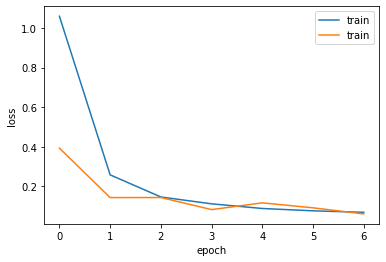

In [15]:
hist_df = pd.DataFrame(hist.history)
hist_df['epoch']=hist.epoch
sns.lineplot(data=hist_df, x='epoch',y='loss', label='train')
sns.lineplot(data=hist_df, x='epoch',y='val_loss', label='train')

<AxesSubplot:xlabel='epoch', ylabel='accuracy'>

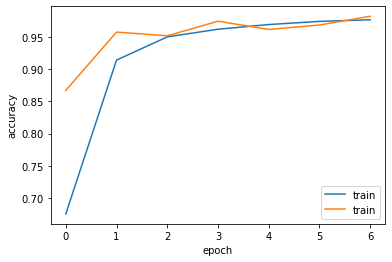

In [16]:
hist_df = pd.DataFrame(hist.history)
hist_df['epoch']=hist.epoch
sns.lineplot(data=hist_df, x='epoch',y='accuracy', label='train')
sns.lineplot(data=hist_df, x='epoch',y='val_accuracy', label='train')

In [44]:
sample_path = "asl-alphabet/asl_alphabet_test/asl_alphabet_test/Z_test.jpg"
img = image.load_img(sample_path, target_size=(TARGET_SIZE, TARGET_SIZE))
x = image.img_to_array(img)
x /= 255
x = np.expand_dims(x, axis=0)

classes = pd.DataFrame(model.predict(x, batch_size=1)).T
class_labels = pd.DataFrame(train_datagen.class_indices.keys())
res = pd.concat([class_labels,classes], axis=1)
res.columns = ['Label','Pred']
p = res.loc[res.Pred==res.Pred.max()]
p.iloc[0]

Label           Z
Pred     0.999999
Name: 25, dtype: object

In [3]:
model = tf.keras.models.load_model("model_asl.h5")

## Model 2

In [46]:
backend.clear_session()
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

In [48]:
model2 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters= 32,kernel_size=(5,5),input_shape =(TARGET_SIZE,TARGET_SIZE,3), activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(32, activation="relu"), 
    tf.keras.layers.Dense(29, activation="softmax")
    ])
model2.compile(
    optimizer='Adam',
    loss="categorical_crossentropy",
    metrics=["accuracy","CategoricalAccuracy"]
)
hist2 = model2.fit(train_datagen, batch_size=TRAIN_BATCH_SIZE, validation_data=val_datagen, 
    epochs=20, callbacks=[early_stop,reduce_lr_on_plateau])

Epoch 1/20
2175/2175 [==============================] - 441s 203ms/step - loss: 1.6541 - accuracy: 0.5124 - categorical_accuracy: 0.5124 - val_loss: 1.4588 - val_accuracy: 0.5015 - val_categorical_accuracy: 0.5015 - lr: 0.0010
Epoch 2/20
2175/2175 [==============================] - 418s 192ms/step - loss: 0.5091 - accuracy: 0.8422 - categorical_accuracy: 0.8422 - val_loss: 0.6018 - val_accuracy: 0.8106 - val_categorical_accuracy: 0.8106 - lr: 0.0010
Epoch 3/20
2175/2175 [==============================] - 419s 193ms/step - loss: 0.2988 - accuracy: 0.9056 - categorical_accuracy: 0.9056 - val_loss: 1.2559 - val_accuracy: 0.6191 - val_categorical_accuracy: 0.6191 - lr: 0.0010
Epoch 4/20
2175/2175 [==============================] - 414s 190ms/step - loss: 0.2200 - accuracy: 0.9290 - categorical_accuracy: 0.9290 - val_loss: 0.7499 - val_accuracy: 0.7564 - val_categorical_accuracy: 0.7564 - lr: 0.0010
Epoch 5/20
2175/2175 [==============================] - ETA: 0s - loss: 0.1742 - accuracy: 0

<AxesSubplot:xlabel='epoch', ylabel='loss'>

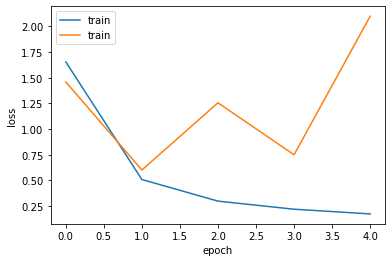

In [49]:
hist2_df = pd.DataFrame(hist2.history)
hist2_df['epoch']=hist2.epoch
sns.lineplot(data=hist2_df, x='epoch',y='loss', label='train')
sns.lineplot(data=hist2_df, x='epoch',y='val_loss', label='train')

<AxesSubplot:xlabel='epoch', ylabel='accuracy'>

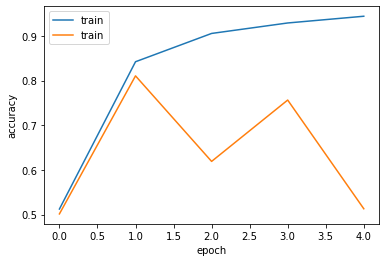

In [50]:
hist2_df = pd.DataFrame(hist2.history)
hist2_df['epoch']=hist2.epoch
sns.lineplot(data=hist2_df, x='epoch',y='accuracy', label='train')
sns.lineplot(data=hist2_df, x='epoch',y='val_accuracy', label='train')

## Model 3

In [52]:
backend.clear_session()
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

In [51]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

pre_trained_model = InceptionV3(input_shape = (TARGET_SIZE, TARGET_SIZE, 3), 
                                include_top = False, 
                                weights = 'imagenet')

87924736/87910968 [==============================] - 35s 0us/step


In [56]:
pre_trained_model.trainable = False
transfer_model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(TARGET_SIZE, TARGET_SIZE, 3)),
    pre_trained_model,
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(128, activation="relu"), 
    tf.keras.layers.Dense(29, activation="softmax")
])

transfer_model.compile(optimizer="Adam", loss='categorical_crossentropy', metrics=["accuracy","CategoricalAccuracy"])
transfer_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 1, 1, 2048)        21802784  
                                                                 
 flatten_3 (Flatten)         (None, 2048)              0         
                                                                 
 dense_6 (Dense)             (None, 128)               262272    
                                                                 
 dense_7 (Dense)             (None, 29)                3741      
                                                                 
Total params: 22,068,797
Trainable params: 266,013
Non-trainable params: 21,802,784
_________________________________________________________________


In [57]:
hist3 = transfer_model.fit(train_datagen, batch_size=TRAIN_BATCH_SIZE, validation_data=val_datagen, 
    epochs=20, callbacks=[early_stop,reduce_lr_on_plateau])

Epoch 1/20
2175/2175 [==============================] - 293s 134ms/step - loss: 0.6335 - accuracy: 0.8159 - categorical_accuracy: 0.8159 - val_loss: 0.2737 - val_accuracy: 0.9130 - val_categorical_accuracy: 0.9130 - lr: 0.0010
Epoch 2/20
2175/2175 [==============================] - 289s 133ms/step - loss: 0.1945 - accuracy: 0.9392 - categorical_accuracy: 0.9392 - val_loss: 0.1581 - val_accuracy: 0.9492 - val_categorical_accuracy: 0.9492 - lr: 0.0010
Epoch 3/20
2175/2175 [==============================] - 284s 130ms/step - loss: 0.1302 - accuracy: 0.9584 - categorical_accuracy: 0.9584 - val_loss: 0.1574 - val_accuracy: 0.9507 - val_categorical_accuracy: 0.9507 - lr: 0.0010
Epoch 4/20
2175/2175 [==============================] - 286s 132ms/step - loss: 0.0973 - accuracy: 0.9686 - categorical_accuracy: 0.9686 - val_loss: 0.1359 - val_accuracy: 0.9576 - val_categorical_accuracy: 0.9576 - lr: 0.0010
Epoch 5/20
2175/2175 [==============================] - 284s 131ms/step - loss: 0.0767 - acc

<AxesSubplot:xlabel='epoch', ylabel='loss'>

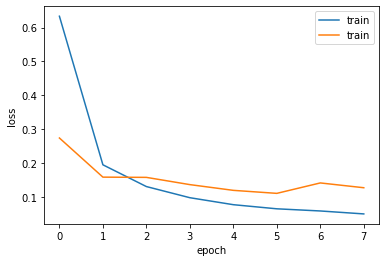

In [60]:
hist3_df = pd.DataFrame(hist3.history)
hist3_df['epoch']=hist3.epoch
sns.lineplot(data=hist3_df, x='epoch',y='loss', label='train')
sns.lineplot(data=hist3_df, x='epoch',y='val_loss', label='train')

<AxesSubplot:xlabel='epoch', ylabel='accuracy'>

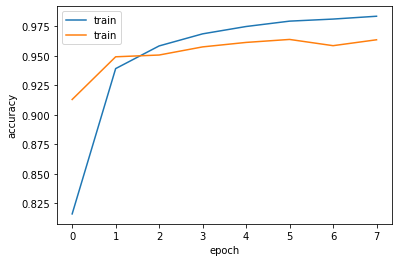

In [61]:
hist3_df = pd.DataFrame(hist3.history)
hist3_df['epoch']=hist3.epoch
sns.lineplot(data=hist3_df, x='epoch',y='accuracy', label='train')
sns.lineplot(data=hist3_df, x='epoch',y='val_accuracy', label='train')

In [62]:
transfer_model.save_weights('model3_asl_weights.h5')
transfer_model.save('model3_asl.h5')

In [64]:
sample_path = "asl-alphabet/asl_alphabet_test/asl_alphabet_test/Z_test.jpg"
img = image.load_img(sample_path, target_size=(TARGET_SIZE, TARGET_SIZE))
x = image.img_to_array(img)
x /= 255
x = np.expand_dims(x, axis=0)

classes = pd.DataFrame(transfer_model.predict(x, batch_size=1)).T
class_labels = pd.DataFrame(train_datagen.class_indices.keys())
res = pd.concat([class_labels,classes], axis=1)
res.columns = ['Label','Pred']
p = res.loc[res.Pred==res.Pred.max()]
p.iloc[0]

Label           Z
Pred     0.999999
Name: 25, dtype: object

In [104]:
test_data = datagen.flow_from_directory(
    'asl-alphabet/asl_alphabet_test/asl_alphabet_test',
    class_mode="categorical",
    target_size=(TARGET_SIZE, TARGET_SIZE),
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=False
)

Found 29 images belonging to 29 classes.


In [105]:
predictions = transfer_model.predict(test_data, verbose=1)
# Get most likely class
predicted_classes = np.argmax(predictions, axis=-1)
predictions = np.argmax(predictions, axis=-1) #multiple categories

true_classes = test_data.classes
class_labels = list(test_data.class_indices.keys())  
report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

1/1 [==============================] - 0s 115ms/step
              precision    recall  f1-score   support

           A       1.00      1.00      1.00         1
           B       1.00      1.00      1.00         1
           C       1.00      1.00      1.00         1
           D       1.00      1.00      1.00         1
           E       1.00      1.00      1.00         1
           F       1.00      1.00      1.00         1
           G       1.00      1.00      1.00         1
           H       1.00      1.00      1.00         1
           I       1.00      1.00      1.00         1
           J       1.00      1.00      1.00         1
           K       1.00      1.00      1.00         1
           L       1.00      1.00      1.00         1
           M       1.00      1.00      1.00         1
           N       1.00      1.00      1.00         1
           O       1.00      1.00      1.00         1
           P       1.00      1.00      1.00         1
           Q       1.00     

## Kesimpulan

Digunakan model pertama karena pada kurva evaluasi, nilai antara validation loss - loss dan validation accuracy dan accuracy paling berhimpit

In [17]:
model.save_weights('model2_asl_weights.h5')
model.save('model2_asl.h5')